In [1]:
# --- Blok 0: Inisialisasi, Fungsi Global, dan Pemuatan Data ---
import pandas as pd
import re
import string
import nltk
import ssl
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from afinn import Afinn
from textblob import TextBlob
from senticnet.senticnet import SenticNet # Pastikan senticnet terinstal
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os # Untuk memeriksa keberadaan file

# --- Konfigurasi dan Download Resource NLTK ---
def download_nltk_resources():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

    resources = {
        "punkt": "tokenizers/punkt",
        "stopwords": "corpora/stopwords",
        "averaged_perceptron_tagger": "taggers/averaged_perceptron_tagger",
        "wordnet": "corpora/wordnet",
        "omw-1.4": "corpora/omw-1.4",
        "sentiwordnet": "corpora/sentiwordnet"
    }
    
    for resource_name, resource_path in resources.items():
        try:
            nltk.data.find(resource_path)
            print(f"[INFO] NLTK resource '{resource_name}' ({resource_path}) sudah ada.")
        except LookupError:
            print(f"[INFO] NLTK resource '{resource_name}' ({resource_path}) tidak ditemukan. Mengunduh...")
            try:
                nltk.download(resource_name, quiet=True)
                print(f"[INFO] Berhasil mengunduh '{resource_name}'.")
            except Exception as e:
                print(f"[ERROR] Gagal mengunduh '{resource_name}': {e}")
                print(f"         Coba jalankan secara manual: nltk.download('{resource_name}')")
        except Exception as e:
            print(f"[ERROR] Error saat memeriksa resource {resource_name}: {e}")

download_nltk_resources()
print("-" * 50)

# Fungsi untuk memberi label sentimen berdasarkan skor
def label_sentiment(score, pos_thresh=0.05, neg_thresh=-0.05):
    if score > pos_thresh:
        return "Positif"
    elif score < neg_thresh:
        return "Negatif"
    else:
        return "Netral"

# --- Pemuatan Data dan Sampling ---
csv_file_path_original = 'Data Pakai Label.csv'
csv_file_path_sample_translated = 'Data_Sample_Translated.csv' # File untuk menyimpan/memuat sampel terjemahan
translated_column_name = 'translated_content'
sample_size = 100
content_column_original = 'content' # Kolom teks asli Bahasa Indonesia

df_sampled_translated = None

# Coba muat sampel yang sudah ditranslasi jika ada
if os.path.exists(csv_file_path_sample_translated):
    try:
        df_sampled_translated = pd.read_csv(csv_file_path_sample_translated)
        if translated_column_name in df_sampled_translated.columns and len(df_sampled_translated) == sample_size:
            print(f"[INFO] Berhasil memuat sampel yang sudah ditranslasi dari: {csv_file_path_sample_translated}")
        else:
            print(f"[INFO] File sampel terjemahan ditemukan ({csv_file_path_sample_translated}) tetapi format/ukuran tidak sesuai. Akan dibuat ulang.")
            df_sampled_translated = None # Reset agar dibuat ulang
    except Exception as e:
        print(f"[PERINGATAN] Gagal memuat file sampel terjemahan ({csv_file_path_sample_translated}): {e}. Akan dibuat ulang.")
        df_sampled_translated = None

if df_sampled_translated is None:
    try:
        df_full = pd.read_csv(csv_file_path_original)
        print(f"[INFO] Berhasil memuat file asli: {csv_file_path_original}")
        print(f"Jumlah baris awal (keseluruhan): {len(df_full)}")

        if content_column_original not in df_full.columns:
            print(f"[ERROR] Kolom '{content_column_original}' tidak ditemukan di {csv_file_path_original}.")
            exit()

        # --- SAMPLING DATA ---
        if len(df_full) > sample_size:
            print(f"[INFO] Melakukan sampling sebanyak {sample_size} baris dari dataset asli.")
            df_to_process = df_full.sample(n=sample_size, random_state=42).reset_index(drop=True)
        else:
            print(f"[INFO] Ukuran dataset ({len(df_full)}) <= sample_size ({sample_size}). Menggunakan seluruh dataset.")
            df_to_process = df_full.copy()
        
        print(f"Jumlah baris untuk diproses/translasi: {len(df_to_process)}")

        # --- FASE 0 (OPSIONAL): Translasi Teks dari Bahasa Indonesia ke Bahasa Inggris ---
        # Jika Anda ingin melakukan translasi otomatis PADA SAMPEL, uncomment bagian di bawah.
        # Pastikan Anda sudah `pip install transformers sentencepiece sacremoses`
        
        from transformers import MarianMTModel, MarianTokenizer
        model_name_translation = "Helsinki-NLP/opus-mt-id-en"

        def translate_batch_hf(texts_series, model_name="Helsinki-NLP/opus-mt-id-en", batch_size=8):
            print(f"[INFO] Memuat model translasi: {model_name}")
            tokenizer = MarianTokenizer.from_pretrained(model_name)
            model = MarianMTModel.from_pretrained(model_name)
            print("[INFO] Model translasi dimuat.")
            
            texts = texts_series.tolist()
            translated_texts = []
            num_batches = (len(texts) + batch_size - 1) // batch_size
            
            for i in range(num_batches):
                start_idx = i * batch_size
                end_idx = min((i + 1) * batch_size, len(texts))
                batch_texts_cleaned = [str(text) if pd.notnull(text) else "" for text in texts[start_idx:end_idx]]
                
                print(f"[INFO] Menerjemahkan batch {i+1}/{num_batches} (ukuran: {len(batch_texts_cleaned)})...")
                try:
                    inputs = tokenizer(batch_texts_cleaned, return_tensors="pt", padding=True, truncation=True, max_length=512)
                    translated_tokens = model.generate(**inputs)
                    batch_translated = [tokenizer.decode(t, skip_special_tokens=True) for t in translated_tokens]
                    translated_texts.extend(batch_translated)
                except Exception as e:
                    print(f"[ERROR] Gagal menerjemahkan batch {i+1}: {e}")
                    translated_texts.extend([""] * len(batch_texts_cleaned))
                time.sleep(0.1)
            return pd.Series(translated_texts, index=texts_series.index)

        # Lakukan translasi HANYA PADA SAMPEL
        print("[INFO] Memulai proses translasi untuk data sampel...")
        start_translate_time = time.time()
        df_to_process[translated_column_name] = translate_batch_hf(df_to_process[content_column_original])
        end_translate_time = time.time()
        print(f"[INFO] Proses translasi sampel selesai dalam {end_translate_time - start_translate_time:.2f} detik.")
        
        # *** BAGIAN INI YANG DITAMBAHKAN UNTUK KASUS TRANSLASI MANUAL ***
        # Jika Anda melakukan translasi manual, pastikan kolom hasil translasi sudah ada di `df_full`
        # dan skrip akan mengambilnya saat sampling.
        # Jika Anda uncomment blok translasi di atas, baris ini tidak akan dieksekusi
        # karena `translated_column_name` sudah dibuat.
        if translated_column_name not in df_to_process.columns:
            # Ini adalah placeholder jika translasi tidak dilakukan di skrip.
            # Idealnya, Anda sudah punya kolom ini di CSV asli jika translasi manual.
            print(f"[PERINGATAN] Kolom '{translated_column_name}' tidak ada. Akan dibuat placeholder dari '{content_column_original}'.")
            print("           Analisis mungkin tidak akurat. Pastikan Anda sudah menerjemahkan data Anda ke kolom ini.")
            df_to_process[translated_column_name] = df_to_process[content_column_original]
        # *** AKHIR BAGIAN TAMBAHAN ***

        df_sampled_translated = df_to_process.copy()

        # Simpan sampel yang sudah (atau dianggap sudah) ditranslasi
        try:
            df_sampled_translated.to_csv(csv_file_path_sample_translated, index=False, encoding='utf-8-sig')
            print(f"[INFO] Sampel yang (dianggap sudah) ditranslasi disimpan ke: {csv_file_path_sample_translated}")
        except Exception as e:
            print(f"[ERROR] Gagal menyimpan file sampel terjemahan: {e}")

    except FileNotFoundError:
        print(f"[ERROR] File asli '{csv_file_path_original}' tidak ditemukan.")
        exit()
    except Exception as e:
        print(f"[ERROR] Terjadi kesalahan saat memuat atau sampling data: {e}")
        exit()

if df_sampled_translated is None:
    print(f"[ERROR] Gagal memuat atau membuat data sampel terjemahan. Harap periksa error sebelumnya.")
    exit()

df = df_sampled_translated.copy() # df sekarang adalah sampel yang sudah ada kolom terjemahannya
print(f"Jumlah baris data yang akan dianalisis: {len(df)}")
print("Contoh data yang akan dianalisis (2 baris pertama):")
print(df.head(2))
print("-" * 50)

[INFO] NLTK resource 'punkt' (tokenizers/punkt) sudah ada.
[INFO] NLTK resource 'stopwords' (corpora/stopwords) sudah ada.
[INFO] NLTK resource 'averaged_perceptron_tagger' (taggers/averaged_perceptron_tagger) sudah ada.
[INFO] NLTK resource 'wordnet' (corpora/wordnet) tidak ditemukan. Mengunduh...
[INFO] Berhasil mengunduh 'wordnet'.
[INFO] NLTK resource 'omw-1.4' (corpora/omw-1.4) tidak ditemukan. Mengunduh...
[INFO] Berhasil mengunduh 'omw-1.4'.
[INFO] NLTK resource 'sentiwordnet' (corpora/sentiwordnet) sudah ada.
--------------------------------------------------
[INFO] Berhasil memuat file asli: Data Pakai Label.csv
Jumlah baris awal (keseluruhan): 10798
[INFO] Melakukan sampling sebanyak 100 baris dari dataset asli.
Jumlah baris untuk diproses/translasi: 100


/home/xerces/anaconda3/envs/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Memulai proses translasi untuk data sampel...
[INFO] Memuat model translasi: Helsinki-NLP/opus-mt-id-en
[INFO] Model translasi dimuat.
[INFO] Menerjemahkan batch 1/13 (ukuran: 8)...
[INFO] Menerjemahkan batch 2/13 (ukuran: 8)...
[INFO] Menerjemahkan batch 3/13 (ukuran: 8)...
[INFO] Menerjemahkan batch 4/13 (ukuran: 8)...
[INFO] Menerjemahkan batch 5/13 (ukuran: 8)...
[INFO] Menerjemahkan batch 6/13 (ukuran: 8)...
[INFO] Menerjemahkan batch 7/13 (ukuran: 8)...
[INFO] Menerjemahkan batch 8/13 (ukuran: 8)...
[INFO] Menerjemahkan batch 9/13 (ukuran: 8)...
[INFO] Menerjemahkan batch 10/13 (ukuran: 8)...
[INFO] Menerjemahkan batch 11/13 (ukuran: 8)...
[INFO] Menerjemahkan batch 12/13 (ukuran: 8)...
[INFO] Menerjemahkan batch 13/13 (ukuran: 4)...
[INFO] Proses translasi sampel selesai dalam 332.54 detik.
[INFO] Sampel yang (dianggap sudah) ditranslasi disimpan ke: Data_Sample_Translated.csv
Jumlah baris data yang akan dianalisis: 100
Contoh data yang akan dianalisis (2 baris pertama):


In [10]:
import nltk
nltk.download('punkt')
import nltk
print(nltk.data.path)



import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /home/xerces/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/xerces/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/xerces/nltk_data...


['/home/xerces/nltk_data', '/home/xerces/anaconda3/envs/venv/nltk_data', '/home/xerces/anaconda3/envs/venv/share/nltk_data', '/home/xerces/anaconda3/envs/venv/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [11]:
# --- Blok 1: Preprocessing Teks Bahasa Inggris ---
print("[FASE 1] Memulai preprocessing teks Bahasa Inggris...")
start_fase1_time = time.time()

# Fungsi-fungsi preprocessing
def to_lowercase(text):
    return text.lower() if isinstance(text, str) else ""

def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_mentions_hashtags(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    return text

def remove_punctuation(text):
    # Simpan tanda apostrof karena penting untuk kontraksi (misal, "don't")
    # punctuation_to_remove = string.punctuation.replace("'", "") 
    # return text.translate(str.maketrans('', '', punctuation_to_remove))
    # Untuk dictionary-based, seringkali lebih baik menghilangkan semua punctuation
    return text.translate(str.maketrans('', '', string.punctuation))


def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_extra_whitespace(text):
    return " ".join(text.split())

stop_words_en = set(nltk_stopwords.words('english'))
# Kata-kata negasi penting, jangan dihapus jika ada di kamus
negation_words = {"not", "no", "n't", "never", "don't", "can't", "isn't"}
stop_words_en = stop_words_en - negation_words

def remove_en_stopwords(tokens):
    return [word for word in tokens if word not in stop_words_en]

lemmatizer = WordNetLemmatizer()
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif nltk_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return None

def lemmatize_tokens_with_pos(tokens):
    nltk_tagged = nltk.pos_tag(tokens)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_sentence

# Pengecekan kolom hasil terjemahan
if translated_column_name not in df.columns:
    print(f"[ERROR] Kolom terjemahan '{translated_column_name}' tidak ada di DataFrame. Pastikan Fase 0 (Translasi) sudah benar.")
    exit()

# Menghapus baris jika teks terjemahan kosong
df.dropna(subset=[translated_column_name], inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"Jumlah baris setelah menghapus NaN di '{translated_column_name}': {len(df)}")

# Pipeline Preprocessing
df['processed_text'] = df[translated_column_name].apply(to_lowercase)
df['processed_text'] = df['processed_text'].apply(remove_urls)
df['processed_text'] = df['processed_text'].apply(remove_mentions_hashtags)
df['textblob_ready_text'] = df['processed_text'].copy() # Untuk TextBlob, sebelum hapus tanda baca sepenuhnya

df['processed_text'] = df['processed_text'].apply(remove_punctuation)
df['processed_text'] = df['processed_text'].apply(remove_numbers)
df['processed_text'] = df['processed_text'].apply(remove_extra_whitespace)

from nltk.tokenize import word_tokenize # Tambahkan/pastikan ini ada di Blok 1
df['tokens'] = df['processed_text'].apply(word_tokenize)
# STOPWORD REMOVAL DI-NONAKTIFKAN untuk dictionary based, bisa diaktifkan jika diperlukan
# df['tokens_no_stopwords'] = df['tokens'].apply(remove_en_stopwords)

df['lemmatized_tokens'] = df['tokens'].apply(lemmatize_tokens_with_pos)

end_fase1_time = time.time()
print(f"[FASE 1] Preprocessing teks selesai dalam {end_fase1_time - start_fase1_time:.2f} detik.")
print("\nContoh hasil preprocessing (5 baris pertama):")
print(df[[translated_column_name, 'processed_text', 'tokens', 'lemmatized_tokens']].head())
print("-" * 50)

[FASE 1] Memulai preprocessing teks Bahasa Inggris...
Jumlah baris setelah menghapus NaN di 'translated_content': 100
[FASE 1] Preprocessing teks selesai dalam 2.02 detik.

Contoh hasil preprocessing (5 baris pertama):
                                  translated_content  \
0                      Very good. Let's get to work.   
1                                               Help   
2                                        Good. Good.   
3                              I hope it's worth it.   
4  It's crazy to ask for a verbic code. There has...   

                                      processed_text  \
0                         very good lets get to work   
1                                               help   
2                                          good good   
3                                i hope its worth it   
4  its crazy to ask for a verbic code there has t...   

                                              tokens  \
0                  [very, good, lets, get, to, work

In [12]:
# --- Blok 2.1: Analisis Sentimen dengan AFINN ---
print("[FASE 2.1] Menerapkan analisis sentimen AFINN...")
start_fase2_1_time = time.time()

afinn_lexicon = Afinn()
def get_afinn_score(tokens):
    if not tokens: return 0
    # Afinn library bisa langsung menerima string, join token lebih baik
    return afinn_lexicon.score(" ".join(tokens))

df['afinn_score'] = df['tokens'].apply(get_afinn_score) # Menggunakan token asli (bukan lemmatized)
df['afinn_label'] = df['afinn_score'].apply(lambda x: label_sentiment(x, pos_thresh=0.1, neg_thresh=-0.1))

end_fase2_1_time = time.time()
print(f"[FASE 2.1] Analisis AFINN selesai dalam {end_fase2_1_time - start_fase2_1_time:.2f} detik.")
print("\nContoh hasil AFINN:")
print(df[[translated_column_name, 'afinn_score', 'afinn_label']].head())
print("-" * 50)

[FASE 2.1] Menerapkan analisis sentimen AFINN...
[FASE 2.1] Analisis AFINN selesai dalam 0.08 detik.

Contoh hasil AFINN:
                                  translated_content  afinn_score afinn_label
0                      Very good. Let's get to work.          3.0     Positif
1                                               Help          2.0     Positif
2                                        Good. Good.          6.0     Positif
3                              I hope it's worth it.          4.0     Positif
4  It's crazy to ask for a verbic code. There has...         -2.0     Negatif
--------------------------------------------------


In [13]:
# --- Blok 2.2: Analisis Sentimen dengan SentiWordNet ---
print("[FASE 2.2] Menerapkan analisis sentimen SentiWordNet...")
start_fase2_2_time = time.time()

def get_sentiwordnet_score(lemmatized_tokens_with_pos_tags):
    if not lemmatized_tokens_with_pos_tags:
        return 0.0, 0.0, 0.0

    sentiment_score_doc = 0.0
    pos_score_doc = 0.0
    neg_score_doc = 0.0
    
    # Kita sudah punya lemmatized_tokens, sekarang tinggal POS taggingnya
    # Jika lemmatized_tokens sudah punya POS tag, langsung gunakan.
    # Jika tidak, lakukan POS tagging pada lemmatized_tokens.
    # Untuk SentiWordNet, kata harus dilematisasi DENGAN POS tag yang benar.

    tagged_tokens = nltk.pos_tag(lemmatized_tokens_with_pos_tags) # POS tag pada token lemmatized

    for word, tag in tagged_tokens:
        wn_tag = nltk_tag_to_wordnet_tag(tag) # Fungsi ini sudah didefinisikan di Blok 1
        if wn_tag not in (nltk.corpus.wordnet.NOUN, nltk.corpus.wordnet.ADJ, 
                           nltk.corpus.wordnet.ADV, nltk.corpus.wordnet.VERB):
            continue

        # Lemmatize lagi dengan POS tag yang benar untuk SentiWordNet
        # (Meskipun sudah dilematisasi, terkadang bentuknya belum 100% dasar tanpa POS spesifik)
        lemma = lemmatizer.lemmatize(word, wn_tag) if wn_tag else word 
        
        synsets = list(swn.senti_synsets(lemma, wn_tag))
        if not synsets:
            # Jika tidak ada synset untuk lemma+tag, coba tanpa tag
            synsets = list(swn.senti_synsets(lemma))
            if not synsets:
                continue
        
        # Ambil skor dari synset pertama (paling umum)
        synset = synsets[0]
        pos_score = synset.pos_score()
        neg_score = synset.neg_score()
        
        pos_score_doc += pos_score
        neg_score_doc += neg_score
        sentiment_score_doc += (pos_score - neg_score)
        
    return pos_score_doc, neg_score_doc, sentiment_score_doc

swn_scores = df['lemmatized_tokens'].apply(get_sentiwordnet_score)
df['swn_pos_score'] = swn_scores.apply(lambda x: x[0])
df['swn_neg_score'] = swn_scores.apply(lambda x: x[1])
df['swn_sentiment_score'] = swn_scores.apply(lambda x: x[2])
df['swn_label'] = df['swn_sentiment_score'].apply(label_sentiment)

end_fase2_2_time = time.time()
print(f"[FASE 2.2] Analisis SentiWordNet selesai dalam {end_fase2_2_time - start_fase2_2_time:.2f} detik.")
print("\nContoh hasil SentiWordNet:")
print(df[[translated_column_name, 'swn_sentiment_score', 'swn_label']].head())
print("-" * 50)

[FASE 2.2] Menerapkan analisis sentimen SentiWordNet...
[FASE 2.2] Analisis SentiWordNet selesai dalam 2.20 detik.

Contoh hasil SentiWordNet:
                                  translated_content  swn_sentiment_score  \
0                      Very good. Let's get to work.                0.875   
1                                               Help                0.500   
2                                        Good. Good.                1.250   
3                              I hope it's worth it.                0.000   
4  It's crazy to ask for a verbic code. There has...                0.000   

  swn_label  
0   Positif  
1   Positif  
2   Positif  
3    Netral  
4    Netral  
--------------------------------------------------


In [14]:
# --- Blok 2.3: Analisis Sentimen dengan SenticNet ---
print("[FASE 2.3] Menerapkan analisis sentimen SenticNet...")
start_fase2_3_time = time.time()

sn = SenticNet()
def get_senticnet_score(tokens_or_lemmas): # Bisa pakai tokens atau lemmatized_tokens
    if not tokens_or_lemmas: return 0.0
    
    score = 0.0
    count = 0
    for token in tokens_or_lemmas:
        try:
            # SenticNet bekerja dengan konsep, jadi lowercase
            concept_info = sn.concept(token.lower()) 
            polarity_value = float(concept_info['polarity_value'])
            score += polarity_value
            count += 1
        except KeyError: # Konsep tidak ditemukan di SenticNet
            continue
    return score / count if count > 0 else 0.0

# Coba dengan lemmatized_tokens karena SenticNet berbasis konsep
df['senticnet_score'] = df['lemmatized_tokens'].apply(get_senticnet_score) 
df['senticnet_label'] = df['senticnet_score'].apply(label_sentiment)

end_fase2_3_time = time.time()
print(f"[FASE 2.3] Analisis SenticNet selesai dalam {end_fase2_3_time - start_fase2_3_time:.2f} detik.")
print("\nContoh hasil SenticNet:")
print(df[[translated_column_name, 'senticnet_score', 'senticnet_label']].head())
print("-" * 50)

[FASE 2.3] Menerapkan analisis sentimen SenticNet...
[FASE 2.3] Analisis SenticNet selesai dalam 0.00 detik.

Contoh hasil SenticNet:
                                  translated_content  senticnet_score  \
0                      Very good. Let's get to work.           0.5455   
1                                               Help           0.9000   
2                                        Good. Good.           0.1910   
3                              I hope it's worth it.           0.5150   
4  It's crazy to ask for a verbic code. There has...           0.6270   

  senticnet_label  
0         Positif  
1         Positif  
2         Positif  
3         Positif  
4         Positif  
--------------------------------------------------


In [15]:
# --- Blok 2.4: Analisis Sentimen dengan TextBlob ---
print("[FASE 2.4] Menerapkan analisis sentimen TextBlob...")
start_fase2_4_time = time.time()

def get_textblob_sentiment(text):
    if not isinstance(text, str) or not text.strip(): # Handle empty or non-string
        return 0.0, 0.0
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Gunakan 'textblob_ready_text' yang masih memiliki beberapa tanda baca
textblob_sentiments = df['textblob_ready_text'].apply(get_textblob_sentiment)
df['textblob_polarity'] = textblob_sentiments.apply(lambda x: x[0])
df['textblob_subjectivity'] = textblob_sentiments.apply(lambda x: x[1])
df['textblob_label'] = df['textblob_polarity'].apply(label_sentiment)

end_fase2_4_time = time.time()
print(f"[FASE 2.4] Analisis TextBlob selesai dalam {end_fase2_4_time - start_fase2_4_time:.2f} detik.")
print("\nContoh hasil TextBlob:")
print(df[[translated_column_name, 'textblob_polarity', 'textblob_label']].head())
print("-" * 50)

[FASE 2.4] Menerapkan analisis sentimen TextBlob...
[FASE 2.4] Analisis TextBlob selesai dalam 0.03 detik.

Contoh hasil TextBlob:
                                  translated_content  textblob_polarity  \
0                      Very good. Let's get to work.               0.91   
1                                               Help               0.00   
2                                        Good. Good.               0.70   
3                              I hope it's worth it.               0.30   
4  It's crazy to ask for a verbic code. There has...              -0.60   

  textblob_label  
0        Positif  
1         Netral  
2        Positif  
3        Positif  
4        Negatif  
--------------------------------------------------


In [16]:
# --- Blok 3: Tampilkan Hasil Gabungan dari Semua Kamus ---
print("[FASE 3] Menampilkan contoh hasil analisis gabungan (10 baris pertama):")

# Pastikan kolom Sentimen Akhir ada untuk perbandingan
ground_truth_col = 'Sentimen Akhir'
columns_to_display = ['content', translated_column_name]
if ground_truth_col in df.columns:
    columns_to_display.append(ground_truth_col)

columns_to_display.extend([
    'afinn_score', 'afinn_label', 
    'swn_sentiment_score', 'swn_label',
    'senticnet_score', 'senticnet_label',
    'textblob_polarity', 'textblob_label'
])

# Filter kolom yang benar-benar ada di DataFrame untuk menghindari error
columns_to_display = [col for col in columns_to_display if col in df.columns]

print(df[columns_to_display].head(10))
print("-" * 50)

[FASE 3] Menampilkan contoh hasil analisis gabungan (10 baris pertama):
                                             content  \
0                       Bagus sekali, cepat kerjanya   
1                                           Membantu   
2                                        bagus bagus   
3                                  Semoga bermanfaat   
4  Gilak mau mintak kode verifiaksi aja harus ada...   
5                                              Bagus   
6                                           Good lah   
7                                               Baik   
8  Sangat memudahkan untuk mencari informasi fasi...   
9                          Bagus dan sangat membantu   

                                  translated_content Sentimen Akhir  \
0                      Very good. Let's get to work.        Positif   
1                                               Help        Positif   
2                                        Good. Good.        Positif   
3                          

[FASE 4] Melakukan evaluasi dan visualisasi...

[INFO] Melakukan evaluasi berdasarkan kolom 'Sentimen Akhir'...

--- Evaluasi untuk Metode: AFINN ---
Akurasi: 0.6700
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Positif       0.92      0.73      0.81        77
      Netral       0.04      0.50      0.07         2
     Negatif       0.71      0.48      0.57        21

    accuracy                           0.67       100
   macro avg       0.56      0.57      0.49       100
weighted avg       0.86      0.67      0.75       100



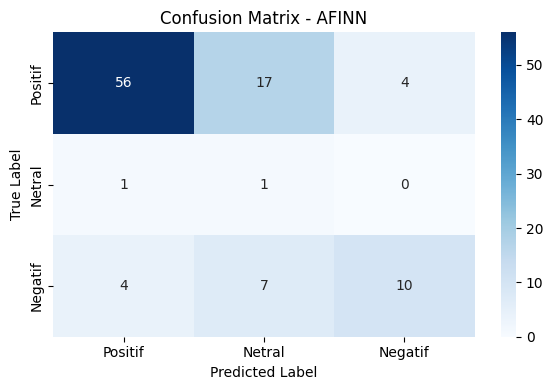


--- Evaluasi untuk Metode: SentiWordNet ---
Akurasi: 0.6100
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Positif       0.86      0.70      0.77        77
      Netral       0.00      0.00      0.00         2
     Negatif       0.37      0.33      0.35        21

    accuracy                           0.61       100
   macro avg       0.41      0.34      0.37       100
weighted avg       0.74      0.61      0.67       100



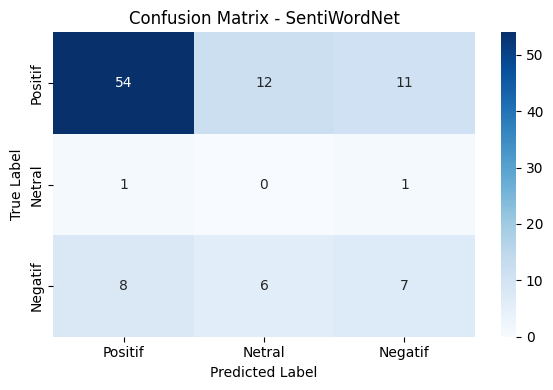


--- Evaluasi untuk Metode: SenticNet ---
Akurasi: 0.6500
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Positif       0.86      0.77      0.81        77
      Netral       0.07      0.50      0.12         2
     Negatif       0.31      0.24      0.27        21

    accuracy                           0.65       100
   macro avg       0.41      0.50      0.40       100
weighted avg       0.73      0.65      0.68       100



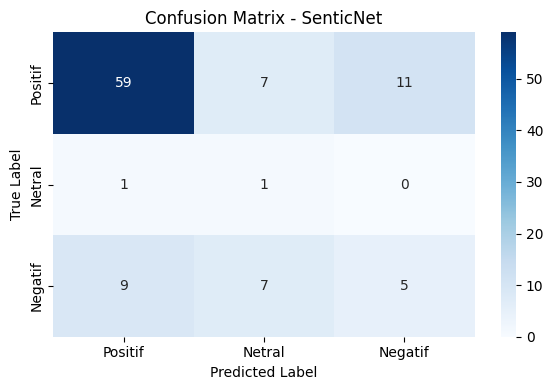


--- Evaluasi untuk Metode: TextBlob ---
Akurasi: 0.6800
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Positif       0.91      0.79      0.85        77
      Netral       0.04      0.50      0.08         2
     Negatif       0.67      0.29      0.40        21

    accuracy                           0.68       100
   macro avg       0.54      0.53      0.44       100
weighted avg       0.84      0.68      0.74       100



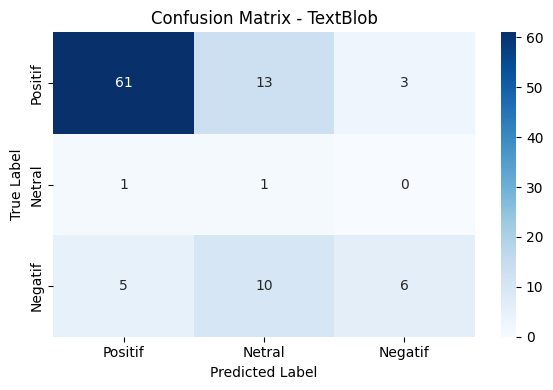



--- Tabel Perbandingan Kinerja Metode ---
         Method  Accuracy  Positif_Precision  Positif_Recall  Positif_F1-Score  Positif_Support  Netral_Precision  Netral_Recall  Netral_F1-Score  Netral_Support  Negatif_Precision  Negatif_Recall  Negatif_F1-Score  Negatif_Support  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1-Score  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1-Score
0         AFINN      0.67           0.918033        0.727273          0.811594             77.0          0.040000            0.5         0.074074             2.0           0.714286        0.476190          0.571429             21.0             0.557440          0.567821            0.485699                0.857685                 0.67               0.746409
1  SentiWordNet      0.61           0.857143        0.701299          0.771429             77.0          0.000000            0.0         0.000000             2.0           0.368421        0.333333          0.350000             21.0       

In [19]:
# --- Blok 4: Evaluasi dan Visualisasi ---
print("[FASE 4] Melakukan evaluasi dan visualisasi...")
start_fase4_time = time.time()

ground_truth_column = 'Sentimen Akhir' # Kolom sentimen manual Anda
evaluation_results = [] # List untuk menyimpan hasil evaluasi

# Fungsi evaluate_sentiments_detailed yang dimodifikasi untuk mengembalikan metrik
def evaluate_sentiments_detailed(y_true, y_pred, method_name, labels_order=["Positif", "Netral", "Negatif"]):
    if len(y_true) == 0 or len(y_pred) == 0 or len(y_true) != len(y_pred):
        print(f"[PERINGATAN] Data tidak valid untuk evaluasi {method_name}. Panjang y_true: {len(y_true)}, y_pred: {len(y_pred)}")
        return None

    valid_indices = y_true.notna() & y_pred.notna()
    y_true_cleaned = y_true[valid_indices]
    y_pred_cleaned = y_pred[valid_indices]

    if len(y_true_cleaned) == 0:
        print(f"[PERINGATAN] Tidak ada data valid setelah membersihkan NaN untuk evaluasi {method_name}.")
        return None

    accuracy = accuracy_score(y_true_cleaned, y_pred_cleaned)
    unique_labels_data = sorted(list(set(y_true_cleaned.unique()) | set(y_pred_cleaned.unique())))
    current_labels_order = [l for l in labels_order if l in unique_labels_data]
    if not current_labels_order: current_labels_order = unique_labels_data

    report_dict = classification_report(y_true_cleaned, y_pred_cleaned, labels=current_labels_order, zero_division=0, output_dict=True)
    cm = confusion_matrix(y_true_cleaned, y_pred_cleaned, labels=current_labels_order)

    print(f"\n--- Evaluasi untuk Metode: {method_name} ---")
    print(f"Akurasi: {accuracy:.4f}")
    print("Laporan Klasifikasi:")
    # Untuk tampilan di konsol, kita bisa print report string
    print(classification_report(y_true_cleaned, y_pred_cleaned, labels=current_labels_order, zero_division=0))
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=current_labels_order, 
                yticklabels=current_labels_order)
    plt.title(f'Confusion Matrix - {method_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    # Kumpulkan metrik untuk tabel perbandingan
    metrics = {'Method': method_name, 'Accuracy': accuracy}
    for label in current_labels_order:
        if label in report_dict:
            metrics[f'{label}_Precision'] = report_dict[label]['precision']
            metrics[f'{label}_Recall'] = report_dict[label]['recall']
            metrics[f'{label}_F1-Score'] = report_dict[label]['f1-score']
            metrics[f'{label}_Support'] = report_dict[label]['support']
        else: # Jika label tidak ada di prediksi sama sekali
            metrics[f'{label}_Precision'] = 0
            metrics[f'{label}_Recall'] = 0
            metrics[f'{label}_F1-Score'] = 0
            metrics[f'{label}_Support'] = 0 # Atau ambil dari y_true.value_counts()
            
    if 'macro avg' in report_dict:
        metrics['Macro_Avg_Precision'] = report_dict['macro avg']['precision']
        metrics['Macro_Avg_Recall'] = report_dict['macro avg']['recall']
        metrics['Macro_Avg_F1-Score'] = report_dict['macro avg']['f1-score']
    if 'weighted avg' in report_dict:
        metrics['Weighted_Avg_Precision'] = report_dict['weighted avg']['precision']
        metrics['Weighted_Avg_Recall'] = report_dict['weighted avg']['recall']
        metrics['Weighted_Avg_F1-Score'] = report_dict['weighted avg']['f1-score']
        
    return metrics


if ground_truth_column in df.columns:
    print(f"\n[INFO] Melakukan evaluasi berdasarkan kolom '{ground_truth_column}'...")
    df_eval = df.copy()
    df_eval.dropna(subset=[ground_truth_column], inplace=True)
    df_eval.reset_index(drop=True, inplace=True)

    if not df_eval.empty:
        # Pastikan kolom label ada sebelum evaluasi
        if 'afinn_label' in df_eval.columns:
            metrics_afinn = evaluate_sentiments_detailed(df_eval[ground_truth_column], df_eval['afinn_label'], "AFINN")
            if metrics_afinn: evaluation_results.append(metrics_afinn)
        else: print("[PERINGATAN] Kolom 'afinn_label' tidak ditemukan untuk evaluasi.")

        if 'swn_label' in df_eval.columns:
            metrics_swn = evaluate_sentiments_detailed(df_eval[ground_truth_column], df_eval['swn_label'], "SentiWordNet")
            if metrics_swn: evaluation_results.append(metrics_swn)
        else: print("[PERINGATAN] Kolom 'swn_label' tidak ditemukan untuk evaluasi.")

        if 'senticnet_label' in df_eval.columns:
            metrics_senticnet = evaluate_sentiments_detailed(df_eval[ground_truth_column], df_eval['senticnet_label'], "SenticNet")
            if metrics_senticnet: evaluation_results.append(metrics_senticnet)
        else: print("[PERINGATAN] Kolom 'senticnet_label' tidak ditemukan untuk evaluasi.")

        if 'textblob_label' in df_eval.columns:
            metrics_textblob = evaluate_sentiments_detailed(df_eval[ground_truth_column], df_eval['textblob_label'], "TextBlob")
            if metrics_textblob: evaluation_results.append(metrics_textblob)
        else: print("[PERINGATAN] Kolom 'textblob_label' tidak ditemukan untuk evaluasi.")
        
        # Membuat tabel perbandingan
        if evaluation_results:
            df_comparison = pd.DataFrame(evaluation_results)
            # Atur urutan kolom agar lebih mudah dibaca
            ordered_columns = ['Method', 'Accuracy']
            labels_for_order = ["Positif", "Netral", "Negatif"] # Sesuai urutan yang diinginkan
            
            for label in labels_for_order:
                if f'{label}_Precision' in df_comparison.columns: # Cek jika kolom ada
                    ordered_columns.extend([f'{label}_Precision', f'{label}_Recall', f'{label}_F1-Score', f'{label}_Support'])
            
            # Tambahkan kolom rata-rata jika ada
            avg_cols_to_check = ['Macro_Avg_Precision', 'Macro_Avg_Recall', 'Macro_Avg_F1-Score', 
                                 'Weighted_Avg_Precision', 'Weighted_Avg_Recall', 'Weighted_Avg_F1-Score']
            for col in avg_cols_to_check:
                if col in df_comparison.columns:
                    ordered_columns.append(col)
            
            # Filter ordered_columns agar hanya berisi kolom yang benar-benar ada di df_comparison
            final_ordered_columns = [col for col in ordered_columns if col in df_comparison.columns]

            df_comparison = df_comparison[final_ordered_columns]
            
            print("\n\n--- Tabel Perbandingan Kinerja Metode ---")
            print(df_comparison.to_string()) # .to_string() untuk tampilan yang lebih baik di konsol
            
            # Simpan tabel perbandingan ke file CSV terpisah
            try:
                comparison_csv_path = 'Data_Perbandingan_Metode_Sentiment.csv'
                df_comparison.to_csv(comparison_csv_path, index=False, encoding='utf-8-sig')
                print(f"\n[INFO] Tabel perbandingan disimpan ke: {comparison_csv_path}")
            except Exception as e:
                print(f"[ERROR] Gagal menyimpan tabel perbandingan: {e}")
        else:
            print("[PERINGATAN] Tidak ada hasil evaluasi yang valid untuk membuat tabel perbandingan.")

    else:
        print(f"[PERINGATAN] Tidak ada data ground truth yang valid di kolom '{ground_truth_column}' untuk evaluasi.")
else:
    print(f"[INFO] Kolom ground truth '{ground_truth_column}' tidak ditemukan. Evaluasi dilewati.")

end_fase4_time = time.time()
print(f"[FASE 4] Evaluasi dan visualisasi selesai dalam {end_fase4_time - start_fase4_time:.2f} detik.")
print("-" * 50)

In [20]:
# --- Blok 5: Penyimpanan Hasil Akhir DataFrame Utama ---
print("[FASE 5] Menyimpan hasil akhir DataFrame utama...")

output_csv_path_main = 'Data_Hasil_Sentiment_Dictionaries_Lengkap.csv' # Ganti nama agar beda dengan tabel perbandingan
try:
    df.to_csv(output_csv_path_main, index=False, encoding='utf-8-sig')
    print(f"\n[INFO] Hasil lengkap (termasuk skor mentah) disimpan ke: {output_csv_path_main}")
except Exception as e:
    print(f"[ERROR] Gagal menyimpan file CSV utama: {e}")

print("--- Proses Selesai ---")

[FASE 5] Menyimpan hasil akhir DataFrame utama...

[INFO] Hasil lengkap (termasuk skor mentah) disimpan ke: Data_Hasil_Sentiment_Dictionaries_Lengkap.csv
--- Proses Selesai ---
